<a href="https://colab.research.google.com/github/akshatahowal/demo/blob/master/ad_clicks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler
from imblearn.over_sampling import SMOTE
import requests
import warnings
from zipfile import ZipFile

In [0]:
%matplotlib inline
warnings.filterwarnings("ignore")


In [0]:
data_url = 'https://drive.google.com/file/d/1oJCM7LJ5oCcI4PuQH6vTFypAzwsMA0Jz/'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "/content/drive/My Drive/Colab Notebooks/ad_clicks1.zip"

ls: cannot access '/content/drive/My Drive/Colab Notebooks/ad_clicks1.zip': No such file or directory


In [0]:
zip_file = ZipFile("/content/drive/My Drive/Colab Notebooks/ad_clicks.zip")

In [0]:
train = pd.read_csv(zip_file.open('train.csv'))

In [0]:
test = pd.read_csv(zip_file.open('test.csv'))

In [0]:
train.head()

,ID,datetime,siteid,offerid,category,merchant,countrycode,browserid,devid,click
0,IDsrk7SoW,2017-01-14 09:42:09,4709696.0,887235,17714,20301556,e,Firefox,NaN,0
1,IDmMSxHur,2017-01-18 17:50:53,5189467.0,178235,21407,9434818,b,Mozilla Firefox,Desktop,0
2,IDVLNN0Ut,2017-01-11 12:46:49,98480.0,518539,25085,2050923,a,Edge,NaN,0
3,ID32T6wwQ,2017-01-17 10:18:43,8896401.0,390352,40339,72089744,c,Firefox,Mobile,0
4,IDqUShzMg,2017-01-14 16:02:33,5635120.0,472937,12052,39507200,d,Mozilla Firefox,Desktop,0


In [0]:
train['datetime']=pd.to_datetime(train['datetime'])
train['hour']=train['datetime'].dt.hour
train['weekday']=train['datetime'].dt.weekday

In [0]:
train['hour'].replace({0:24},inplace=True)

In [0]:
train.drop('ID',axis=1,inplace=True)

In [0]:
x = train.drop('click',axis=1)
y = train['click']

In [0]:
x['siteid'].replace({np.NaN:0},inplace=True)

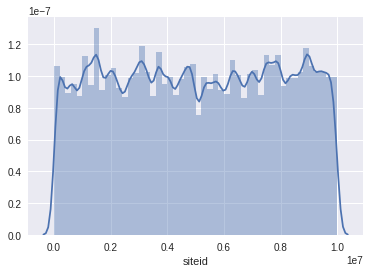

In [0]:
sns.distplot(x['siteid'])

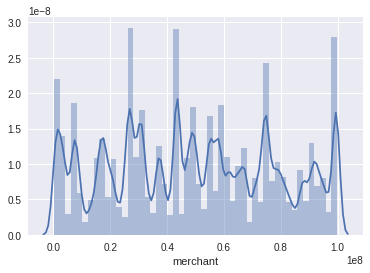

In [0]:
sns.distplot(x['merchant'])

In [0]:
train['daytime'] = pd.cut(train['hour'],[1,7,13,19,25],labels=['night','morning','afternoon','evening'])
train['daytime'].value_counts()

morning      5504731
afternoon    5314789
night        1125002
evening       178737
Name: daytime, dtype: int64

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12137810 entries, 0 to 12137809
Data columns (total 12 columns):
datetime       datetime64[ns]
siteid         float64
offerid        int64
category       int64
merchant       int64
countrycode    object
browserid      object
devid          object
click          int64
hour           int64
weekday        int64
daytime        category
dtypes: category(1), datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 1.0+ GB


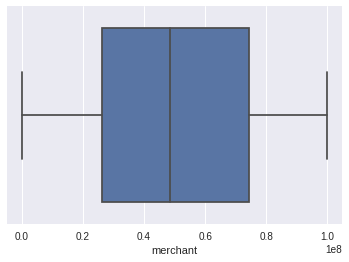

In [0]:
sns.boxplot(x['merchant'])

In [0]:
features = ['countrycode','devid','browserid','weekday','hour','daytime']

In [0]:
def plotcounts(df,feature):
  fig, axes = plt.subplots(1,3,figsize=(15,5))
  g = sns.countplot(x=feature,data=df,ax=axes[0])
  plt.xticks(rotation=60)
  sns.countplot(x=feature,hue='click',data=df,ax=axes[1])
  train1 = df[df['click']==1]
  sns.countplot(x=feature,hue='click',data=train1,ax=axes[2])

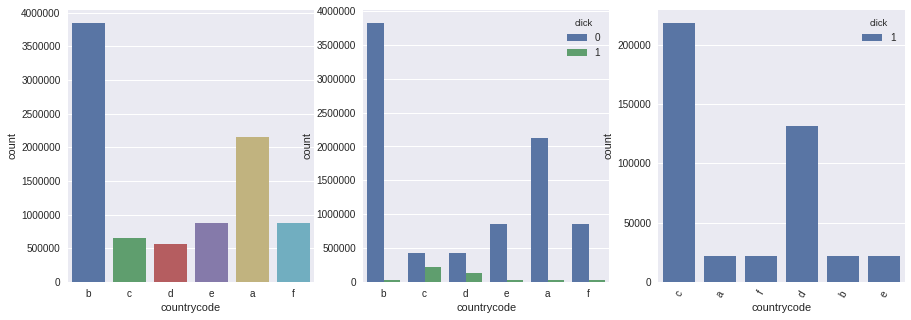

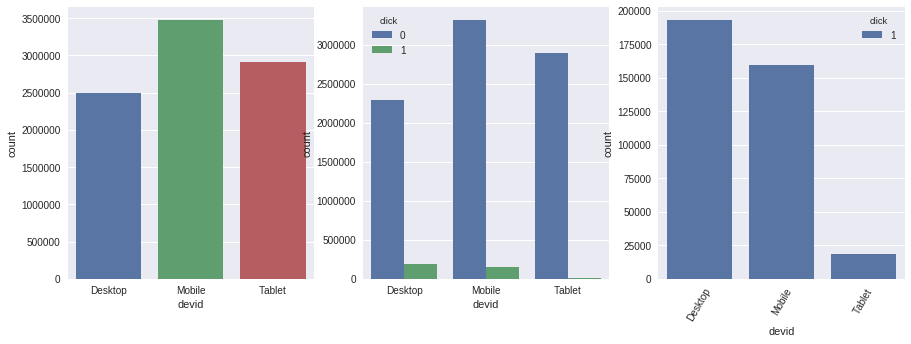

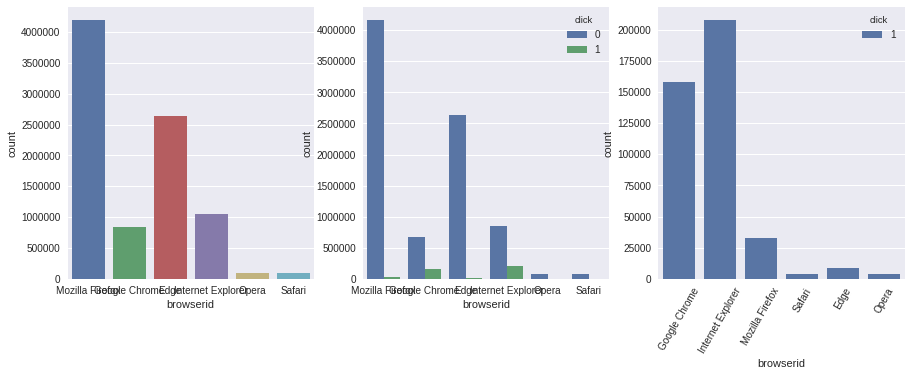

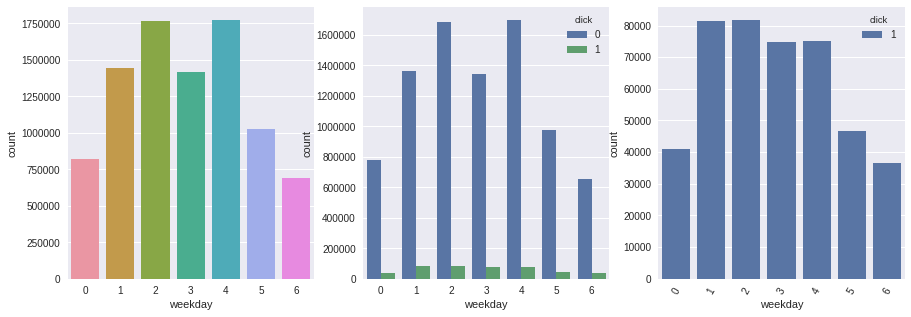

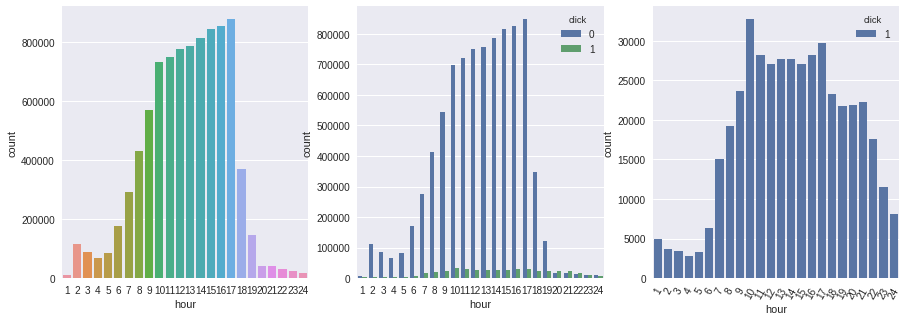

In [0]:
for feature in features:
  plotcounts(train,feature)

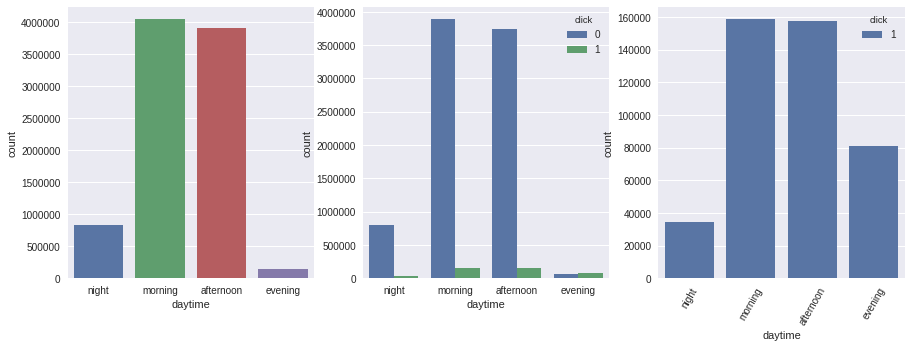

In [0]:
#plotcounts(train,'daytime')

In [0]:
#plotcounts(train,'countrycode')
#plotcounts(train,'devid')
#plotcounts(train,'browserid')

In [0]:
train['browserid'].unique()

array(['Firefox', 'Mozilla Firefox', 'Edge', 'Google Chrome', nan,
       'Mozilla', 'Chrome', 'IE', 'InternetExplorer', 'Opera',
       'Internet Explorer', 'Safari'], dtype=object)

In [0]:
train['browserid'].replace({'Firefox':'Mozilla Firefox','Mozilla':'Mozilla Firefox','Chrome':'Google Chrome',
                            'IE':'Internet Explorer','InternetExplorer':'Internet Explorer'},inplace=True)


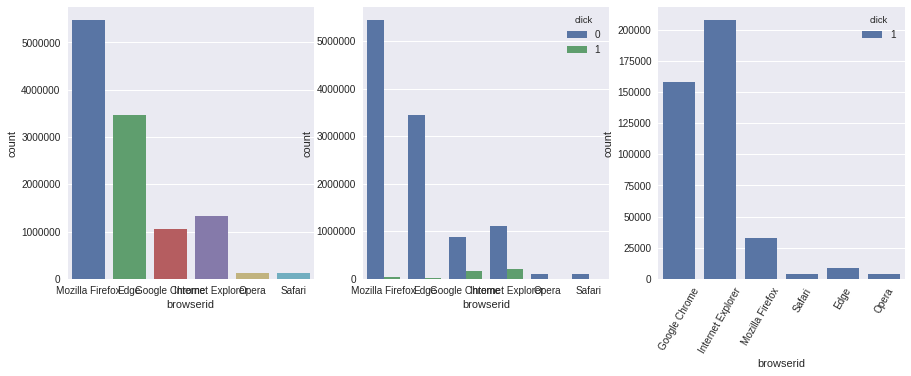

In [0]:
plotcounts(train,'browserid')

In [0]:
train.isnull().sum()

datetime             0
siteid         1212515
offerid              0
category             0
merchant             0
countrycode          0
browserid       608327
devid          1820299
click                0
hour                 0
weekday              0
dtype: int64

In [0]:
def remove_nulls(df,feature):
  train1 = df[df['click']==0 ]
  train1 = train1[train1[feature].isnull()]
  null_rows = list(train1.index)
  return df.drop(null_rows,axis=0)

In [0]:
train = remove_nulls(train,'devid')
train.shape

(10383544, 12)

In [0]:
train = remove_nulls(train,'siteid')
train.shape

(9389749, 12)

In [0]:
train = remove_nulls(train,'browserid')
train.shape

(8941327, 12)

In [0]:
train = train.reset_index().drop('index',axis=1)

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8941327 entries, 0 to 8941326
Data columns (total 11 columns):
datetime       datetime64[ns]
siteid         float64
offerid        int64
category       int64
merchant       int64
countrycode    object
browserid      object
devid          object
click          int64
hour           int64
weekday        int64
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 750.4+ MB


In [0]:
train[train['click']==1]['devid'].value_counts()

Mobile     294718
Desktop    132684
Tablet       9812
Name: devid, dtype: int64

In [0]:
train[train['click']==1]['browserid'].value_counts()

Mozilla Firefox      226869
Internet Explorer    119111
Google Chrome         82503
Edge                   4445
Safari                 2188
Opera                  2098
Name: browserid, dtype: int64

In [0]:
crosstab = pd.crosstab(index=train["browserid"], columns=train["devid"])
crosstab

devid,Desktop,Mobile,Tablet
browserid,,,
Edge,0,0,2645881
Google Chrome,265174,548883,0
Internet Explorer,584550,265416,177645
Mozilla Firefox,1630152,2562152,0
Opera,0,88591,0
Safari,0,0,88423


In [0]:
train['siteid'] = train['siteid'].interpolate('nearest')

In [0]:
m1 = train['hour']>9
m2 = train['hour']<18

In [0]:

train['browserid'] = np.where(train['browserid'].isnull()==True & m1 & m2,'Mozilla Firefox',train['browserid'])
train['browserid'] = np.where(train['browserid'].isnull()==True,'Internet Explorer',train['browserid'])

In [0]:
train['devid'] = np.where(train['devid'].isnull()==True & m1 & m2,'Mobile',train['devid'])
train['devid'] = np.where(train['devid'].isnull()==True,'Desktop',train['devid'])
#train['devid'] = train['devid'].interpolate('nearest')

In [0]:
crosstab = pd.crosstab(index=train["browserid"], columns=train["devid"])
crosstab

devid,Desktop,Mobile,Tablet
browserid,,,
Edge,0,620,1929147
Google Chrome,191199,387398,0
Internet Explorer,395529,216436,127978
Mozilla Firefox,1222528,4341857,494
Opera,0,64106,0
Safari,0,319,63716


In [0]:
#sns.pairplot(train,hue='click',vars=['siteid','offerid','category','merchant'])

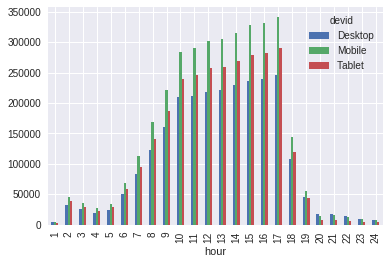

In [0]:
#crosstab_hour_devid = pd.crosstab(index=train["hour"], columns=train["devid"])
#crosstab_hour_devid.plot(kind='bar')

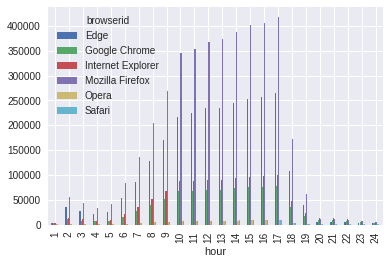

In [0]:
#crosstab_hour_browserid = pd.crosstab(index=train["hour"], columns=train["browserid"])
#crosstab_hour_browserid.plot(kind='bar')

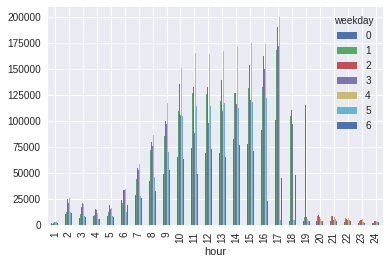

In [0]:
crosstab_hour_weekday = pd.crosstab(index=train["hour"], columns=train["weekday"])
crosstab_hour_weekday.plot(kind='bar')

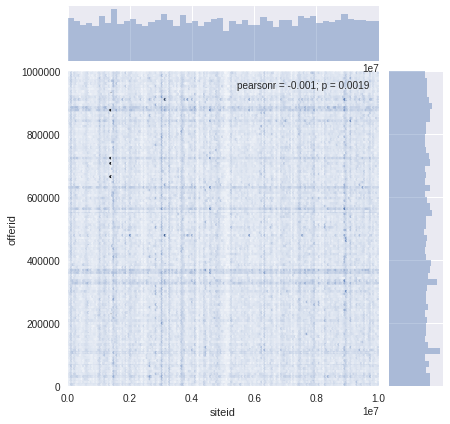

In [0]:
sns.jointplot('siteid','offerid',data=train,kind='hex')

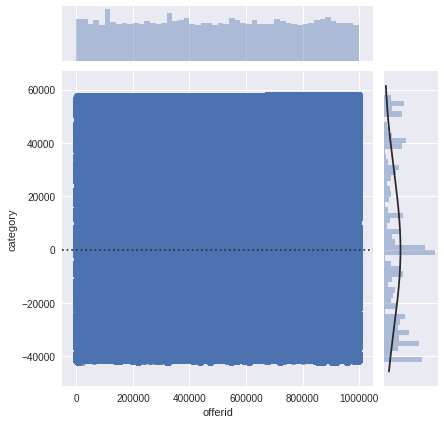

In [0]:
sns.jointplot('offerid','category',data=train,kind='resid')

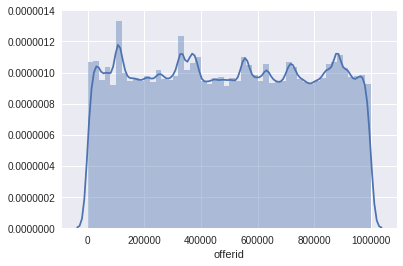

In [0]:
sns.distplot(train['offerid'])

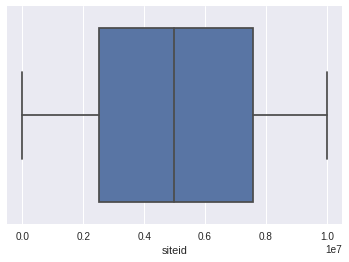

In [0]:
sns.boxplot(train['siteid'])

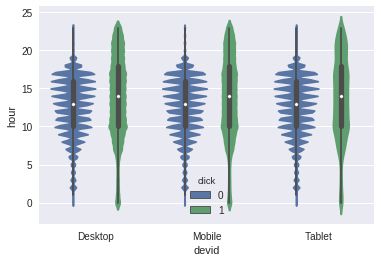

In [0]:
sns.violinplot('devid','hour',data=train,hue='click')

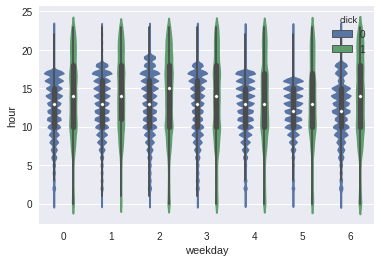

In [0]:
sns.violinplot('weekday','hour',data=train,hue='click')

In [0]:
x = train.drop('click',axis=1)
y = train['click']

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y,test_size=0.3,random_state=0)

In [0]:

def target_encode(trn_series=None, tst_series=None, target=None, min_samples_leaf=1,smoothing=1):
    #assert len(trn_series) == len(target)
    #assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(trn_series.to_frame(trn_series.name),
                             averages.reset_index().rename(columns={'index': target.name, target.name: 'average'})
                             ,on=trn_series.name,how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(tst_series.to_frame(tst_series.name),
                             averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
                             on=tst_series.name,how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return ft_trn_series,ft_tst_series

In [0]:
x_train["datetime"], x_test["datetime"] = target_encode(x_train["datetime"], x_test["datetime"],
                                                        
                         target=y_train, min_samples_leaf=100,smoothing=10)
x_train["countrycode"], x_test["countrycode"] = target_encode(x_train["countrycode"], x_test["countrycode"],
                         target=y_train, min_samples_leaf=100,smoothing=10)
x_train["browserid"], x_test["browserid"] = target_encode(x_train["browserid"], x_test["browserid"],
                         target=y_train, min_samples_leaf=100,smoothing=10)
x_train["devid"], x_test["devid"] = target_encode(x_train["devid"], x_test["devid"],
                         target=y_train, min_samples_leaf=100,smoothing=10)
x_train["hour"], x_test["hour"] = target_encode(x_train["hour"], x_test["hour"],
                         target=y_train, min_samples_leaf=100,smoothing=10)
x_train["weekday"], x_test["weekday"] = target_encode(x_train["weekday"], x_test["weekday"],
                         target=y_train, min_samples_leaf=100,smoothing=10)
x_train["daytime"], x_test["daytime"] = target_encode(x_train["daytime"], x_test["daytime"],
                         target=y_train, min_samples_leaf=100,smoothing=10)

In [0]:
train.isnull().sum()

datetime           0
siteid             0
offerid            0
category           0
merchant           0
countrycode        0
browserid          0
devid              0
click              0
hour               0
weekday            0
daytime        11894
dtype: int64

In [0]:

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [0]:
cc = ClusterCentroids(random_state=0)
x_sample, y_sample = cc.fit_sample(x_train,y_train)
lr_cc = LogisticRegression(random_state=0)
lr_cc.fit(x_sample,y_sample)

In [0]:

y_lr = lr_cc.predict(x_sample)
recall_cc = recall_score(y_sample,y_lr)
cm_cc = confusion_matrix(y_sample,y_lr)

print(recall_score,cm_cc,sep='\n')

In [0]:
rus = RandomUnderSampler(random_state=0)
x_sample, y_sample = rus.fit_sample(x_train,y_train)
lr_rus = LogisticRegression(random_state=0,class_weight='balanced')
lr_rus.fit(x_sample,y_sample)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [0]:
y_lr = lr_rus.predict(x_sample)
recall_rus = recall_score(y_sample,y_lr)
cm_rus = confusion_matrix(y_sample,y_lr)

print(recall_rus,cm_rus,sep='\n')

0.545214834177422
[[147126 158924]
 [139187 166863]]


In [0]:
y_lr = lr_rus.predict(x_train)
recall_rus = recall_score(y_train,y_lr)
cm_rus = confusion_matrix(y_train,y_lr)

print(recall_rus,cm_rus,sep='\n')

0.545214834177422
[[2853958 3098920]
 [ 139187  166863]]


In [0]:
y_lr = lr_rus.predict(x_test)
recall_rus = recall_score(y_test,y_lr)
cm_rus = confusion_matrix(y_test,y_lr)

print(recall_rus,cm_rus,sep='\n')

0.545736635052301
[[1223870 1327365]
 [  59583   71581]]


In [0]:
smt = SMOTE(random_state=0)
x_sample, y_sample = smt.fit_sample(x_train,y_train)
lr_smt = LogisticRegression(random_state=0,class_weight='balanced')
lr_smt.fit(x_sample,y_sample)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [0]:
y_lr_smt = lr_smt.predict(x_train)
recall_smt = recall_score(y_train,y_lr_smt)
cm_smt = confusion_matrix(y_train,y_lr_smt)

print(recall_smt,cm_smt,sep='\n')

0.5380722104231335
[[2906735 3046143]
 [ 141373  164677]]


In [0]:
y_lr_smt = lr_smt.predict(x_train)
recall_smt = recall_score(y_train,y_lr_smt)
cm_smt = confusion_matrix(y_train,y_lr_smt)

print(recall_smt,cm_smt,sep='\n')